# import

In [1]:
import os
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import statistics
import json
from PIL import Image, ImageDraw, ImageFont
import seaborn as sns;
import pickle

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()

def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file or 'PORT' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)


def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)


# Function to find corresponding number in another column
def find_corresponding(nums,df_dict):
    return [df_dict[num] for num in nums]

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
#     plt.show()
    plt.close()
    
    
def load_in_paths(pp_file, PP_PATH, DAT_PATH,run_index,ignore_list):
    mir = '_'.join(pp_file.split('_')[0:3])
    print(str(run_index+1) + '/' + str(len(os.listdir(PP_PATH))-1) + '-------------------------------------------------------------------------')
    print(pp_file)
    mouse_session_recording = pp_file.split('_')[0] + '_' + pp_file.split('_')[1] + '_' + pp_file.split('_')[2] 
    skip = False
    for item in ignore_list:
        if item == mouse_session_recording:
            skip = True

    save_path = PP_PATH + pp_file + '\\_final_analysis_output\\'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    ## set dat_path:
    for file_ in os.listdir(DAT_PATH):
        if mouse_session_recording.split('_')[0] in file_:
            if mouse_session_recording.split('_')[1] == file_[-1]:
                dat_path = os.path.join(DAT_PATH,file_)
    for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
        if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
            dat_path = os.path.join(dat_path,recording)

    # set tracking path
    for file_ in os.listdir(dat_path + r"\video\tracking\\"):
        if 'EJT' in mir:
            if 'task' in file_:
                if not 'clock' in file_:
                    tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
        else:
            tracking_path = dat_path + r"\video\tracking\\"
            

    return mir,mouse_session_recording,save_path,tracking_path,dat_path

def load_PPSEQ_data(PP_PATH,pp_file,dat_path,mouse_session_recording):

    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
    ## LOAD 
    print("LOADING PPSEQ DATA")
    print('\n')
    #The assignment history frame (assigment_hist_frame.csv): Spikes by iterations, how each spike is assigned to a sequence ID (in latent_event_hist) or to background (-1)
    assignment_history_df = pd.read_csv(PP_PATH + pp_file + r"\assigment_hist_frame.csv")

    # latent_event_hist.csv: history of latent events. All latent events across all iterations have a row
    latent_event_history_df = pd.read_csv(PP_PATH + pp_file + r"\latent_event_hist.csv")

    # seq_type_log_proportions: log p of each type of sequence at each iteration
    seq_type_log_proportions_df = pd.read_csv(PP_PATH + pp_file + r"\seq_type_log_proportions.csv")

    # neuron_responses.csv: iterations x neurons by 3(number of sequences). Each neuron has three parameters per sequence to describe how it is influenced by each sequence type. 
    # Each iteration these are resampled, therefore there are number of neurons by iterations by 3 by number of sequences of these numbers.
    neuron_response_df = pd.read_csv(PP_PATH + pp_file + r"\neuron_response.csv")

    masking = False
    for dat_files in os.listdir(PP_PATH + pp_file):
        if 'unmasked_spikes' in dat_files:
            masking = True
            print('masking was used')

    if masking == True:
        #log_p_hist.csv: the history of the log_p of the model
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\test_log_p_hist.csv")

        unmasked_spikes_df = pd.read_csv(PP_PATH + pp_file + r"\unmasked_spikes.csv")
    else:
        log_p_hist_df = pd.read_csv(PP_PATH + pp_file + r"\log_p_hist.csv")

        spikes_file = os.path.join(PP_PATH + pp_file,'trainingData\\') + mouse_session_recording + '.txt'
        neuron_ids, spike_times= [], []
        with open(spikes_file) as f:
            for (i, line) in enumerate(f.readlines()):
                neuron_id, spike_time = line.split('\t')
                spike_time = float(spike_time.strip())
                neuron_id = float(neuron_id)
                spike_times.append(spike_time)
                neuron_ids.append(neuron_id)
        unmasked_spikes_df = pd.DataFrame({'neuron':neuron_ids,'timestamp':spike_times}) 
        bkgd_log_proportions_array = pd.read_csv(PP_PATH + pp_file + r"\bkgd_log_proportions_array.csv")

    # Opening JSON file
    f = open(PP_PATH + pp_file + r'\config_file.json')
    # returns JSON object as a dictionary
    config = eval(json.load(f))
    print(f'      done')

    ## LOAD behaviour data
    print('\n')
    print("LOADING BEHAV DATA")

    ## load in the timespan used for pppseq:
    input_params_path = os.path.join(PP_PATH + pp_file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
    # Opening JSON file
    f = open(input_params_path)
    # returns JSON object as 
    # a dictionary
    input_config = json.load(f)
    behav_time_interval_start = input_config['time_span']
    print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")

    ### load in data:
    for sub_file in os.listdir(dat_path + '\\behav_sync\\'):
        if 'task' in sub_file:
            behav_sync_path = dat_path + '\\behav_sync\\' + sub_file +'\\'
    behav_sync = pd.read_csv(behav_sync_path + 'Behav_Ephys_Camera_Sync.csv')
    transitions = pd.read_csv(behav_sync_path + 'Transition_data_sync.csv')

    return assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start



def plot_save_log_l_curve(log_p_hist_df,save_path):
    # find 95% of growth value and when it crossed this
    max_ = max(log_p_hist_df.x1)
    min_ = min(log_p_hist_df.x1)
    growth = max_ - min_
    _prcntile =  max_ - (0.02 * growth)

    ## model log likley hood curve
    plt.plot(log_p_hist_df.x1)
    plt.axhline(y=_prcntile, color='r', linestyle='--')

    SaveFig('log_l_curve.png',save_path)
    
def plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, save_path):
    # calculate interval timings and end points
    interval_lengths = []
    for interval in behav_time_interval_start:
        interval_lengths += [np.diff(interval)[0]]
    total_time = sum(interval_lengths)
    interval_end_points = np.cumsum(interval_lengths)

    # Plot sequences - basic
    timeframe = [0, total_time]
    mask = (spikes_df.timestamp > timeframe[0]) * (spikes_df.timestamp < timeframe[-1])

    # Define neuron order
    neuron_permute_loc = np.zeros(len(neuron_index))
    for i in range(len(neuron_index)):
        neuron_permute_loc[i] = int(list(neuron_index).index(i))
    neuron_order = neuron_permute_loc[(spikes_df.neuron - 1).astype(int)]

    # Plotting
    fig, [ax, ax2] = plt.subplots(2, 1, figsize=(20, 20))

    # Plot background in grey
    background_keep_mask = (spikes_df[mask].sequence_type_adjusted < 0) | (spikes_df[mask].sequence_type_adjusted >= 7.0)
    ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],
               marker='o', s=40, linewidth=0, color='lightgrey', alpha=0.3)
    c_ = np.array(colors)[spikes_df[mask][background_keep_mask].sequence_type_adjusted.values.astype(int)]
    ax2.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],
                marker='o', s=40, linewidth=0, color=c_, alpha=0.3)
    ax2.set_title('extra sequences and background only')

    # Plot spikes without background
    background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0) * \
                             (spikes_df[mask].sequence_type_adjusted != 7.0) * \
                             (spikes_df[mask].sequence_type_adjusted != 8.0)
    c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
    ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],
               marker='o', s=40, linewidth=0, color=c_, alpha=1)
    ax.set_title('held sequences in color and extra sequences + background in grey')

    for end_p in interval_end_points:
        ax.axvline(x=end_p, color='k')

    # Save the figure
    plt.savefig(save_path)
    plt.show()
    return interval_end_points,neuron_order


def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def split_list(numbers):
    chunks = []
    indices = []
    current_chunk = []
    current_indices = []
    for i, num in enumerate(numbers):
        if num == 0:
            if current_chunk:
                chunks.append(current_chunk)
                indices.append(current_indices)
                current_chunk = []
                current_indices = []
        else:
            current_chunk.append(num)
            current_indices.append(i)
    if current_chunk:
        chunks.append(current_chunk)
        indices.append(current_indices)
    return chunks, indices

def cluster_events(start_times, end_times, threshold):
    clusters = []
    for i in range(len(start_times)):
        event_added = False
        for cluster in clusters:
            for index in cluster:
                if (start_times[i] <= end_times[index] + threshold and end_times[i] >= start_times[index] - threshold):
                    cluster.append(i)
                    event_added = True
                    break
            if event_added:
                break
        if not event_added:
            clusters.append([i])
    return clusters

def catagorize_seqs(real_order,num_dominant_seqs,order):
    
    #deal wih the fact that the way I order the sequence messes up the order a bit
    if not len(real_order) == num_dominant_seqs:
        dominant = real_order[0:num_dominant_seqs]
        other_ = real_order[num_dominant_seqs::]
    else:
        dominant = real_order
        other_ = []

    amounts = []
    relative_amounts = []
    pair_outcomes = []
    pairs = []
    for sequence in order:
        ordered = 0
        reverse = 0
        repeat = 0
        misordered = 0
        non_to_task = 0
        task_to_non = 0
        other = 0
        for index,element in enumerate(sequence[0:-1]):
            pair = [element,sequence[index+1]]
            outcome = (logic_machine_for_pair_catagorisation(pair,dominant,other_))
            if outcome == 'ordered':
                ordered +=1
            elif outcome == 'reverse':
                reverse +=1
            elif outcome == 'repeat':
                repeat +=1
            elif outcome == 'misordered':
                misordered +=1
            elif outcome == 'task to other':
                task_to_non +=1
            elif outcome == 'other to task':
                non_to_task +=1
            elif outcome == 'other':
                other +=1
            pairs += [pair]
            pair_outcomes += [[outcome]]
        pairs += [[None]]
        pair_outcomes += [[None]]

        relative_amounts += [list(np.array([ordered,reverse,repeat,misordered,non_to_task,task_to_non,other])/(len(sequence)-1))]
        amounts += [[ordered,reverse,repeat,misordered,non_to_task,task_to_non,other]]
        
    return relative_amounts, amounts,pair_outcomes,pairs

def logic_machine_for_pair_catagorisation(pair,dominant,other):
    # if first one in dominant check for ordering:
    if pair[0] in dominant and pair[-1] in dominant:
        if pair_in_sequence(pair,dominant):
            return('ordered')
        elif pair_in_sequence(pair,dominant[::-1]):
            return('reverse')
        elif pair[-1] == pair[0]:
            return('repeat')
        elif pair[-1] in dominant:
            return('misordered') 
    # if its not these  options then check if it could be in the extra task seqs
    elif pair[0] in  (dominant + other) and pair[-1] in  (dominant + other):
        for item in other:
            if pair[0] in  (dominant + [item]):
                if pair_in_sequence(pair,(dominant + [item])):
                    return('ordered')
                elif pair_in_sequence(pair,(dominant + [item])[::-1]):
                    return('reverse')
                elif pair[-1] == pair[0]:
                    return('repeat')
                elif pair[-1] in (dominant + [item]):
                    return('misordered')  
        # if not this then check if both are in the extra seqs (and are not a repeat):
        if pair[0] in other and pair[-1] in other:
            if not pair[-1] == pair[0]: 
                return('ordered')
    else:
        # if item 1 is in but item 2 isnt then task to other 
        if pair[0] in  (dominant + other):
            if not pair[-1] in  (dominant + other):
                return('task to other')
        # if item 2 is in but item 1 isnt then other to task 
        elif not pair[0] in  (dominant + other):
            if pair[-1] in  (dominant + other):
                return('other to task')
            else:
                return('other')
    return print('ERROR!')

def pair_in_sequence(pair, sequence):
    for i in range(len(sequence) - 1):
        if sequence[i] == pair[0] and sequence[i + 1] == pair[1]:
            return True
        # because its ciruclar:
        elif sequence[-1] == pair[0] and sequence[0] == pair[1]:
            return True
    return False

def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups


def plot_event_transitions(event_transitions,axes,title):
    transitions = list(event_transitions.keys())
    counts = list(event_transitions.values())

    # Create a bar chart
    axes.bar(range(len(transitions)), counts,alpha = 0.5)

    # Set x-axis labels
    labels = [str(transition) for transition in transitions]
    axes.set_xticks(range(len(transitions)), labels, rotation=90)

    # Set y-axis label
    axes.set_ylabel('Normalized Occurrences %')

    # Add title
    axes.set_title('Event Transitions' + title)

def count_event_transitions(event_list):
    
    ### change code so that it sets each dictionary with these pairs a sa starting point! 
    from itertools import product
    numbers = range(1, 7)  # Numbers 1 to 6a
    all_possible_pairs = list(product(numbers, repeat=2))

    transitions = {key: 0 for key in all_possible_pairs}  # Create an empty dictionary with the defined keys
    
    total_transitions = len(event_list) - 1
    
    for i in range(total_transitions):
        current_event = event_list[i]
        next_event = event_list[i + 1]
        transition = (current_event, next_event)
        if transition in transitions:
            transitions[transition] += 1
        else:
            transitions[transition] = 1
    
    normalized_transitions = {}
    for transition, count in transitions.items():
        normalized_count = count / total_transitions * 100
        normalized_transitions[transition] = normalized_count
    
    return normalized_transitions


def normalize_counts_to_percentages(events_dict):
    total_count = sum(events_dict.values())
    normalized_dict = {}

    for event, count in events_dict.items():
        percentage = (count / total_count) * 100
        normalized_dict[event] = percentage

    return normalized_dict

def SaveFig_noclose(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    
def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type

# Function to find corresponding number in another column
def find_corresponding(nums):
    return [df_dict[num] for num in nums]

def split_list(nums):
    sublists = []
    current_sublist = [nums[0]]
    current_element = nums[0]
    for i in range(1,len(nums)):
        if nums[i] == current_element:
            current_sublist.append(nums[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [nums[i]]
            current_element = nums[i]
    sublists.append(current_sublist)
    return sublists

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)

def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.show()
    plt.close()

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def load_H5_bodypart_new_data(tracking_path,video_type,exclude, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if not exclude in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]

    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))

    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)

def load_H5_ports_newdata(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
        
    return(port1,port2,port3,port4,port5)

# Function to find the closest index using np.searchsorted
def find_closest_indices(timestamps, target_times):
    indices = np.searchsorted(timestamps, target_times)
    indices = np.clip(indices, 1, len(timestamps) - 1)  # Ensure indices are within bounds
    
    # Compare target_time with its neighbors to find the closest
    left_indices = indices - 1
    right_indices = indices
    left_diffs = np.abs(timestamps[left_indices] - target_times)
    right_diffs = np.abs(timestamps[right_indices] - target_times)
    
    return np.where(left_diffs <= right_diffs, left_indices, right_indices)

def expand_bounding_box(points, expansion_ratio=0.1):
    """
    Expands an axis-aligned bounding box around given points by a given ratio.
    
    Args:
        points (ndarray): Array of shape (n, 2) with x, y coordinates.
        expansion_ratio (float): Proportion by which to expand the box size.
    
    Returns:
        (x_min, x_max, y_min, y_max): Expanded bounding box coordinates.
    """
    x_min, y_min = points.min(axis=0)
    x_max, y_max = points.max(axis=0)

    x_center = (x_max + x_min) / 2
    y_center = (y_max + y_min) / 2

    x_half_range = (x_max - x_min) / 2 * (1 + expansion_ratio)
    y_half_range = (y_max - y_min) / 2 * (1 + expansion_ratio)

    return (x_center - x_half_range, x_center + x_half_range,
            y_center - y_half_range, y_center + y_half_range)
    
def align_tracking_to_behaviour(behav_sync, poke_in_times, timeframe, behav_time_interval_start):
    # behav_mask: mask for the time interval 
    mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])
    # Find the difference between PokeIN_EphysTime and the start of the behavior interval
    interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
    # Find the offset between the first poke in time and the start of the timeframe
    tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]
    # Get the first synced time for the camera in the interval 
    interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
    # Align the tracking start with the ephys by subtracting the offset
    cam_start_time = interval_cam_times - tracking_offset
    return cam_start_time

def get_cam_ts_inds(back_cam_timestamps_df,cam_start_time, timeframe, bin_size):
    # + bin size & + 1 to make it 1 longer to later make start and end arrays  
    event_times = np.linspace(cam_start_time,cam_start_time + np.diff(timeframe)[0] + bin_size ,int(np.diff(timeframe)[0] /bin_size)+1)
    #convert these to cameraframes - find the frame which is clostest to that time
    # Convert the time stamps to a NumPy array for efficient searching
    timestamps = back_cam_timestamps_df['Time Stamps'].values
    # Find closest indices for all target times
    cam_ts_inds = find_closest_indices(timestamps, np.array(event_times))

    return cam_ts_inds

def Define_task_period_plot_ports(ax,behav_sync,back_p1,back_p2,back_p3,back_p4,back_p5):
    # find the start and end frames for the back camera during task period
    back_cam_task_period_s,back_cam_task_period_e = behav_sync.backcam_trialstart_closest_cameraframes.values[0], behav_sync.backcam_trialstart_closest_cameraframes.values[-1]
    # make a mask to cut down to this period. 
    task_period_backcam_mask = (back_p1.index.values > back_cam_task_period_s) * (back_p1.index.values < back_cam_task_period_e)

    port_locations = []
    for item in [back_p1[task_period_backcam_mask],back_p2[task_period_backcam_mask],back_p3[task_period_backcam_mask],back_p4[task_period_backcam_mask],back_p5[task_period_backcam_mask]]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
        port_locations += [[np.median(item['interped_x'].values),np.median(item['interped_y'].values)]]
        
    return port_locations, task_period_backcam_mask

def process_raw_timestamps(full_org_dat_path):

    track_path = os.path.join(full_org_dat_path,'video/videos/')
    for item in os.listdir(track_path):
        if 'task' in item:
            full_track_path = os.path.join(track_path,item)
            
    for tracking_file in os.listdir(full_track_path):
        if 'back' in tracking_file and '.csv' in tracking_file:
            timestammps_csv = os.path.join(full_track_path,tracking_file)
            break
        
    raw_cam_ts = pd.read_csv(timestammps_csv)

    if len(raw_cam_ts.columns) > 1:
        raw_cam_ts.columns = ['trigger', 'timestamps', 'blank']
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)
    else:
        raw_cam_ts[['trigger', 'timestamps', 'blank']] = raw_cam_ts.iloc[:, 0].str.split(expand=True)
        raw_cam_ts.drop(raw_cam_ts.columns[0], axis=1, inplace=True)
        raw_cam_ts.trigger = raw_cam_ts.trigger.astype(float)

    timestamp_df = process_camera_data(raw_cam_ts)
    
    return timestamp_df

def process_camera_data(Camera_ts_raw):

    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)
    
    # #pull out video name
    # video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            # 'DataPath': ([TimeStampPath] * len(Camera_ts))
            })
        
    return Camera_dataframe


def converttime(time):
    #offset = time & 0xFFF
    cycle1 = (time >> 12) & 0x1FFF
    cycle2 = (time >> 25) & 0x7F
    seconds = cycle2 + cycle1 / 8000.
    return seconds

def uncycle(time):
    cycles = np.insert(np.diff(time) < 0, 0, False)
    cycleindex = np.cumsum(cycles)
    return time + cycleindex * 128

def convert_uncycle_Timestamps(Camera_ts):
    ##################   Convert the timestamps into seconds and uncycle them:
    t_stamps = {}  
    stamps_s = []
    for indx, row in Camera_ts.iterrows():
        if row.trigger > 0: 
            timestamp_new = converttime(int(row.timestamps))
            stamps_s.append(timestamp_new)
        # else:    
        #     raise ValueError('Timestamps are broken')
    t_stamps = uncycle(stamps_s)
    t_stamps = t_stamps - t_stamps[0] # make first timestamp 0 and the others relative to this 
    return(t_stamps)

def check_timestamps(t_stamps, Frame_rate):
    # plot 1/(diff between time stamps). This tells you roughly the frequency and if you've droppped frames.
    Frame_gaps = 1/np.diff(t_stamps)
    Frames_dropped = 0
    for gaps in Frame_gaps:
        if gaps < (Frame_rate-5) or gaps > (Frame_rate+5):
            Frames_dropped = Frames_dropped + 1
    print('Frames dropped = ' + str(Frames_dropped))

    plt.suptitle('Frame rate = ' + str(Frame_rate) + 'fps', color = 'red')
    frame_gaps = plt.hist(Frame_gaps, bins=100)
    plt.xlabel('Frequency')
    plt.ylabel('Number of frames')
    plt.close()
    
def find_trigger_states(Camera_ts_raw):
    triggers = Camera_ts_raw.trigger.values[np.where(Camera_ts_raw.loc[:,'trigger']>0)]
    down_state = list(triggers)[0]
    down_state_times = np.where(triggers == down_state)
    Triggers_temp = np.ones(len(triggers))
    for index in down_state_times:
        Triggers_temp[index] = 0
    trigger_state = Triggers_temp
    return trigger_state

def load_sync_file(mouse_org_data_path,mouse):
    current_animals_behav_sync_path = os.path.join(mouse_org_data_path, r"behav_sync\\")
    for stage in os.listdir(current_animals_behav_sync_path):
        if 'post' in stage:
            sync_path = current_animals_behav_sync_path + stage + '\\'
    if mouse == '148_2_2':
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv', encoding='cp1252')
    else:
        sync_df = pd.read_csv(sync_path + r'Postsleep_Ephys_Camera_sync.csv')
        
    return sync_df 


# find example replay 

In [2]:
# '136_1_3'
# '136_1_4'
# '149_1_1'
# '178_1_4'
# '178_1_7'
# '178_1_8'
# '178_1_9'

mouse = '178_1_7'

awake_PPpath = r'Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\'
sleep_PPpath = r'Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\postsleep\\'

colors = ['---',
'#4ba5bf',
'#ffd061',
'#ed6e5f',
'#C6963E',
'#9ac66a',
'#3a465f',
'#264999']



get awake sequences and tracking

In [3]:
PP_PATH = awake_PPpath
mouse_session_recording =  mouse

        
        
# DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"
DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"


## set ppseq file
for file_ in os.listdir(PP_PATH):
    if mouse_session_recording in file_:
        file = file_
        
save_path = PP_PATH + file + '\\analysis_output\\'
        
## set dat_path:
for file_ in os.listdir(DAT_PATH):
    if mouse_session_recording.split('_')[0] in file_:
        if mouse_session_recording.split('_')[1] == file_[-1]:
            dat_path = os.path.join(DAT_PATH,file_)
for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
    if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
        dat_path = os.path.join(dat_path,recording)
        
# set tracking path
for file_ in os.listdir(dat_path + r"\video\tracking\\"):
    if 'seq' in mouse_session_recording or 'ap5' in mouse_session_recording:
        tracking_path = os.path.join(dat_path + r"\video\tracking\\")
    else:
        if 'task' in file_:
            if not 'clock' in file_:
                tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
# set video paths
for file_ in os.listdir(dat_path + r"\video\videos\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
            for vid_file in os.listdir(cam_path):
                if 'back' in vid_file and '.avi' in vid_file:
                    back_cam_avi_path = os.path.join(cam_path,vid_file)
                if 'side' in vid_file and '.avi' in vid_file:
                    side_cam_avi_path = os.path.join(cam_path,vid_file)
                    

print('\n')
print("LOADING processed_spike_data")
### load in releavent things:

import pickle
with open(PP_PATH + file + "\\analysis_output\\" + "latent_event_history_df_split.pickle", "rb") as input_file:
    latent_event_history_df_split = pickle.load(input_file)
    
with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
    spikes_seq_type_adjusted = pickle.load(input_file)
    
neuron_order = np.load(PP_PATH + file + "\\analysis_output\\" + 'neuron_order.npy')

ordered_preferred_type = np.load(PP_PATH + file + "\\analysis_output\\" + 'ordered_preferred_type.npy')

neuron_index = np.load(PP_PATH + file + "\\analysis_output\\" + 'neuron_index.npy')



# Opening JSON file
f = open(PP_PATH + file + r'\config_file.json')
# returns JSON object as a dictionary
config = eval(json.load(f))


##### load deeplabcut tracking data
print('\n')
print("LOADING DLC TRACKING DATA")


if 'seq' in mouse_session_recording or 'ap5' in mouse_session_recording:
    
    back_head_centre = load_H5_bodypart_new_data(tracking_path,'BACK','PORTS','head_centre')
    if 'port_centroids.txt' in os.listdir(dat_path + r"\video\videos\\"):
        # load in the txt file
        port_centroids = pd.read_csv(dat_path + r"\video\videos\port_centroids.txt", sep="\t")
        pc = True
    else:
        pc = False
        back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports_newdata(tracking_path,'PORTS')

else:
    back_head_centre = load_H5_bodypart(tracking_path,'back','head_centre')
    back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports(tracking_path,'back')


## load in the timespan used for pppseq:
input_params_path = os.path.join(PP_PATH + file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
# Opening JSON file
f = open(input_params_path)
# returns JSON object as  a dictionary
input_config = json.load(f)
behav_time_interval_start = input_config['time_span'][0]
print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")


## LOAD behaviour data
print('\n')
print("LOADING BEHAV DATA")
behav_sync = pd.read_csv(dat_path + r'\behav_sync\2_task\Behav_Ephys_Camera_Sync.csv')
transitions = pd.read_csv(dat_path + r'\behav_sync\2_task\Transition_data_sync.csv')

behav_mask = (behav_sync.PokeIN_EphysTime>behav_time_interval_start[0])*(behav_sync.PokeIN_EphysTime<behav_time_interval_start[1])
poke_in_times = (behav_sync[behav_mask].PokeIN_EphysTime) - behav_time_interval_start[0]
ports = behav_sync[behav_mask].Port
print('done')



LOADING processed_spike_data


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_41516\3686811992.py:55: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  spikes_seq_type_adjusted = pickle.load(input_file)


OSError: [Errno 22] Invalid argument

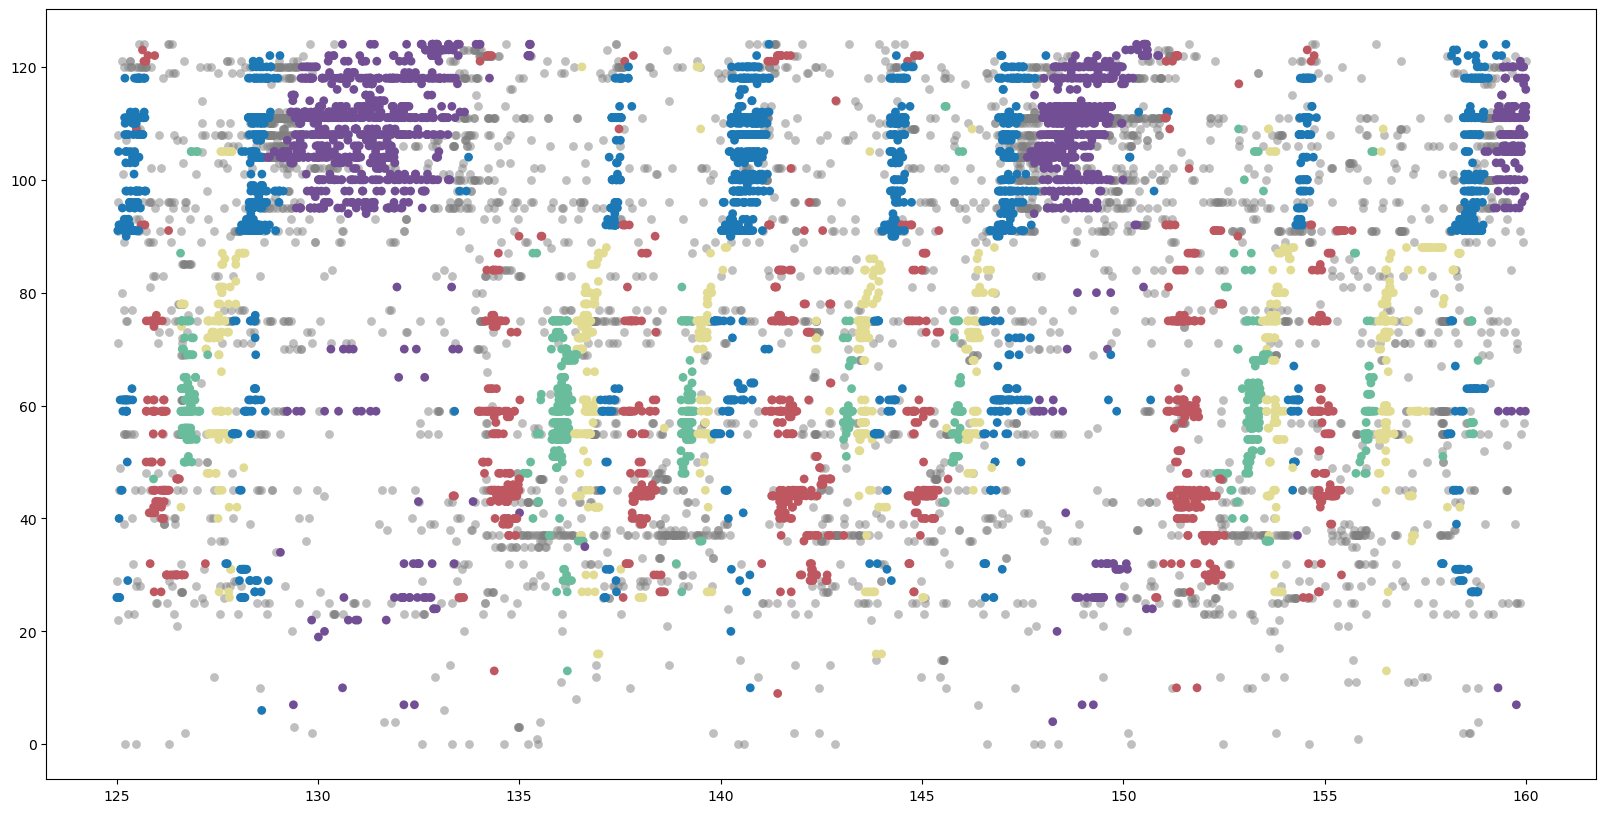

In [ ]:
### Plot sequences - basic
timeframe = [125,160]
mask = (spikes_seq_type_adjusted.timestamp>timeframe[0])*(spikes_seq_type_adjusted.timestamp<timeframe[-1])


# load awake order
with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_index"), "rb") as input_file:
    neuron_index = pickle.load(input_file)
    
with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\colors"), "rb") as input_file:
    colors = pickle.load(input_file)
    
    
with open(os.path.join(os.path.join(PP_PATH,file) + r"\analysis_output\reordered_recolored\neuron_order"), "rb") as input_file:
    neuron_order = pickle.load(input_file)

# #define neuron order
# neuron_permute_loc = np.zeros(len(neuron_index))
# for i in range(len(neuron_index)):
#     neuron_permute_loc[i] = int(list(neuron_index).index(i))
    
# neuron_ids = spikes_seq_type_adjusted.neuron.values
# neuron_order = neuron_permute_loc[(neuron_ids-1).astype(int)]
    

## plotting:
fig, ax = plt.subplots(1, 1,figsize=(20, 10))
# plot background in grey 
background_keep_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted <= 0
ax.scatter(spikes_seq_type_adjusted[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
# plot spikes without background
background_remove_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[spikes_seq_type_adjusted[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(spikes_seq_type_adjusted[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

SaveFig('awake_replay_example.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_26816\1904947695.py:32: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



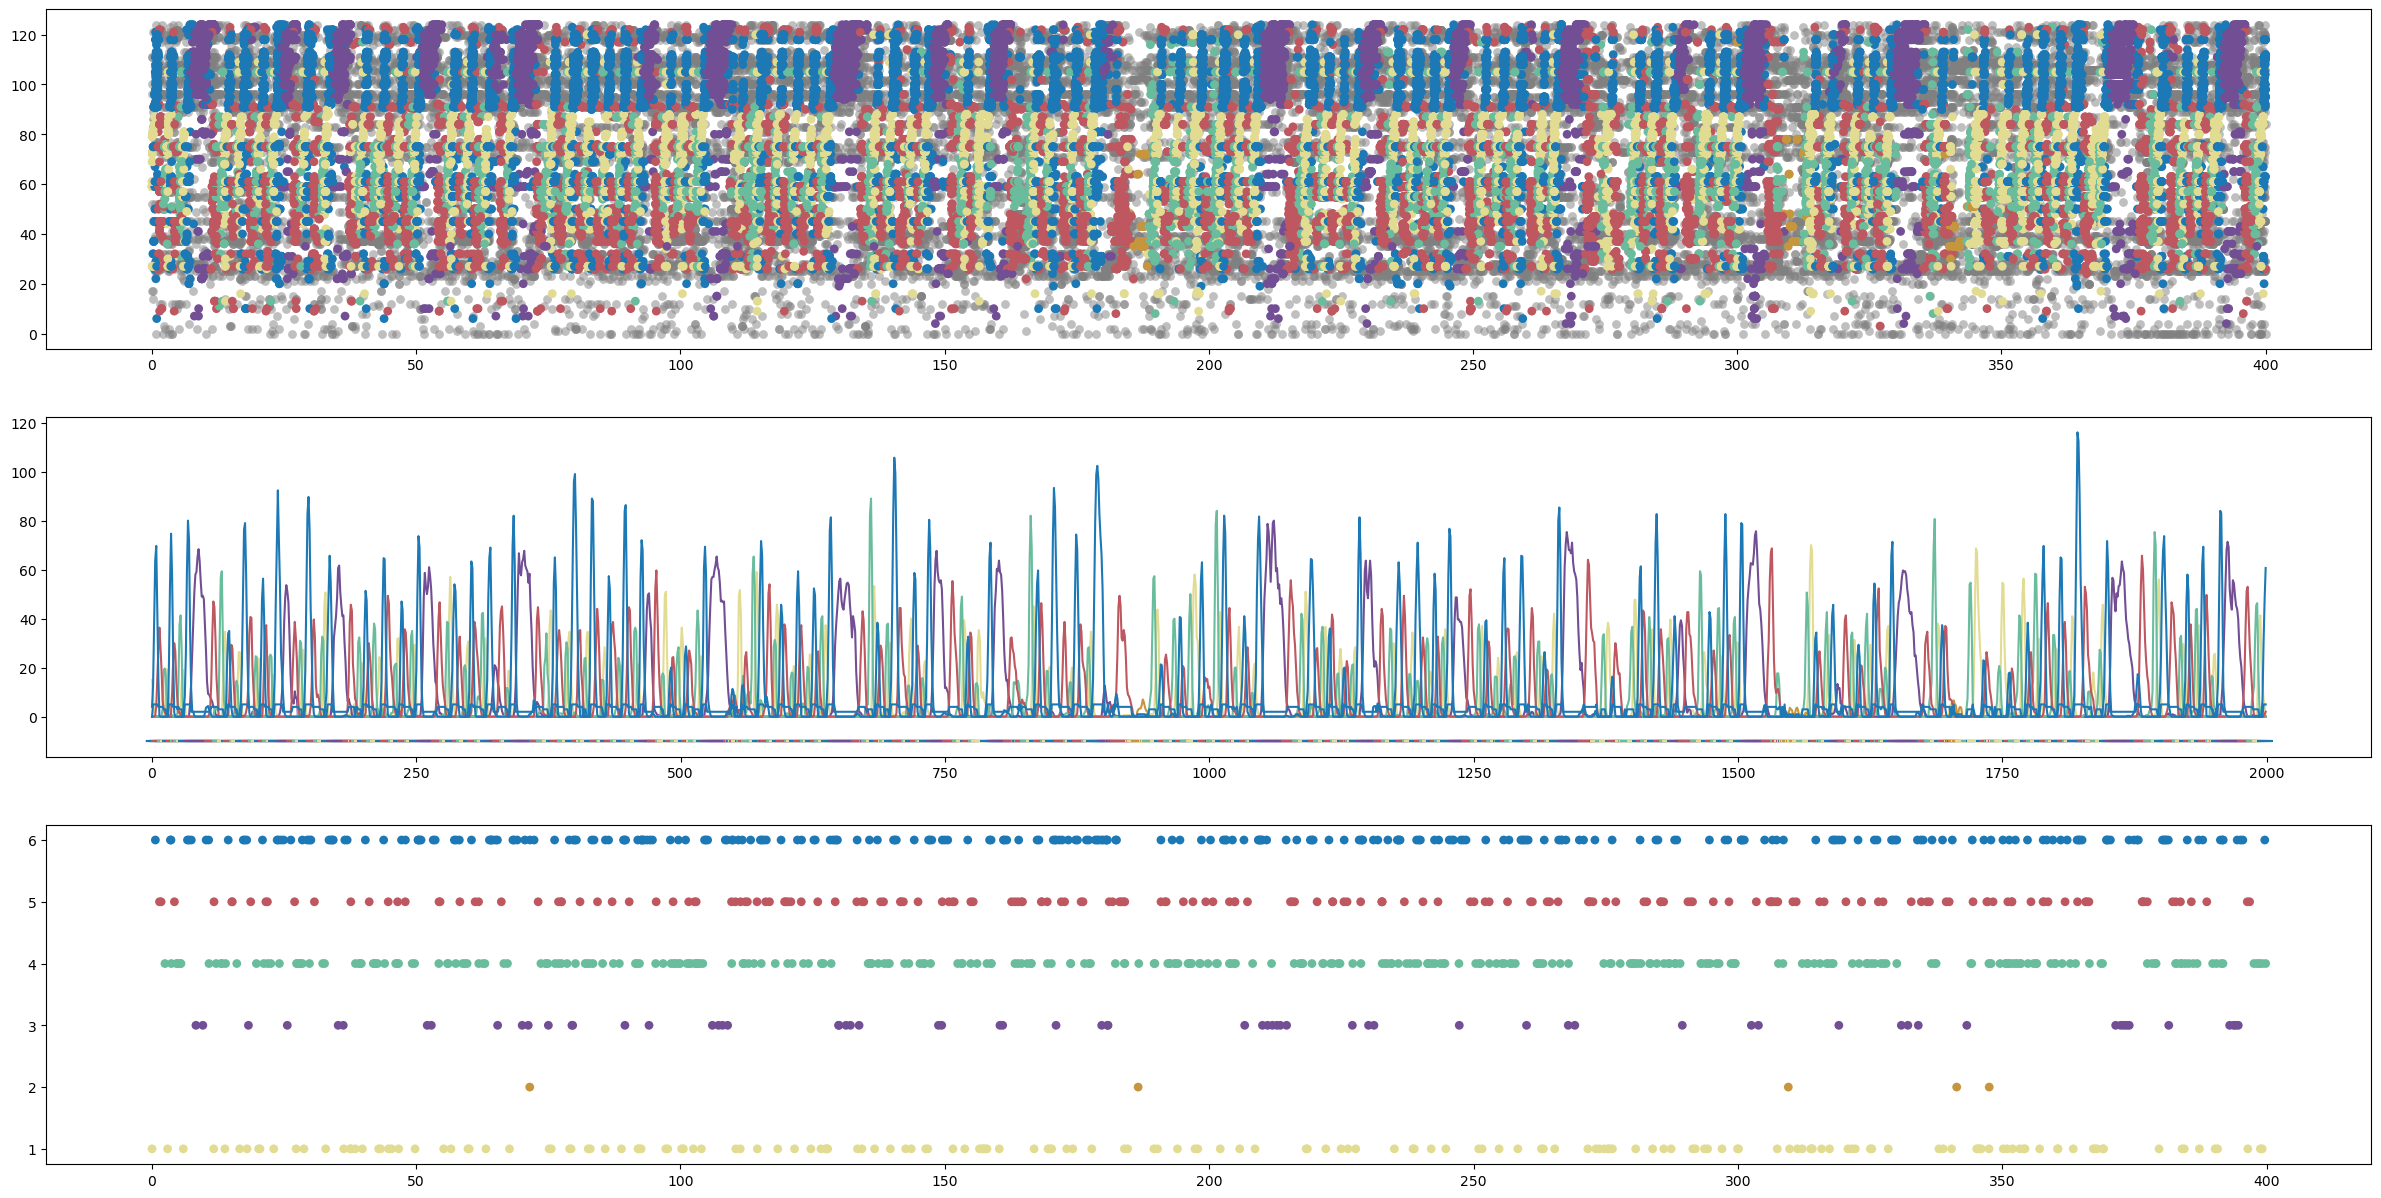

In [ ]:
timeframe = [0,599]

#mask
# spikemask
mask = (spikes_seq_type_adjusted.timestamp>timeframe[0])*(spikes_seq_type_adjusted.timestamp<timeframe[-1])

fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

1 ### plot ordered ppseq spikes as above:

# plot background in grey 
background_keep_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted <= 0
ax1.scatter(spikes_seq_type_adjusted[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
# mask to remove background neurons from the color plot
background_remove_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[spikes_seq_type_adjusted[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
ax1.scatter(spikes_seq_type_adjusted[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(spikes_seq_type_adjusted.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [spikes_seq_type_adjusted.timestamp[np.where(spikes_seq_type_adjusted.sequence_type_adjusted ==seq_type_)[0]].values]

# Define the bin size (in this case, 0.2s)
bin_size = 0.2

seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]
    
strt_ = int(timeframe[0]/bin_size)
end_ = int(timeframe[1]/bin_size)

for i in range (1,len(seq_spike_occurance)):
#     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
    ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])
    

## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

ax2.plot(max_index[strt_:end_])

ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

### plot the ppseq latent:

# mask for the timespan
latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

# ignore anything that is below threshold * max amplitude
thr_ = 0
thresh_value = max(latent_event_history_df_split.amplitude) * thr_


amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)


In [ ]:
# plot out awake example with tracking. 
#plot tracking psoition coloured by current dominant sequence 
# load in the back camera timestamps
back_cam_timestamps_df = None
for files in os.listdir(dat_path + r'\video\videos\\'):
    if '.csv' in files:
        if 'BACK' in files and not 'PORT' in files:
            back_cam_timestamps_df = pd.read_csv(dat_path + r'\video\videos\\'+ files)
            print(f'loading in camera timestamps from: {dat_path}')
if back_cam_timestamps_df is None:
    # process/uncycle the raw timestamps
    back_cam_timestamps_df = process_raw_timestamps(dat_path)

# Define the bin size (in this case, 0.2s)
bin_size = 0.2




# 1) ALIGNMENT: tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 
cam_start_time = align_tracking_to_behaviour(behav_sync, poke_in_times, timeframe, behav_time_interval_start)

# 2) BINNING: create event bins based on the bin sizes defined in the previous cell 
cam_ts_inds = get_cam_ts_inds(back_cam_timestamps_df,cam_start_time, timeframe, bin_size)

# 3) START AND END INDS: for each bin, find the start and end camera inds for plotting the head position (bin start to end):
start_ts = cam_ts_inds[0:-1]
end_ts = cam_ts_inds[1::]

# 4) PLOT THE PORT LOCATIONS:
fig, ax = plt.subplots(1, 1,figsize=(10, 6))

closest_matches = []
for time in behav_sync.backcam_trialstart_seconds.unique():
    idx = (back_cam_timestamps_df['Time Stamps'] - time).abs().idxmin()
    closest_value = back_cam_timestamps_df.loc[idx, 'Time Stamps']
    closest_matches.append({
        "trial_start": time,
        "closest_timestamp": closest_value,
        "cam_fame": idx
    })
closest_df = pd.DataFrame(closest_matches)
behav_sync.backcam_trialstart_closest_cameraframes = closest_df.cam_fame[behav_sync.Trial_id -1 ]

port_locations, task_period_backcam_mask = Define_task_period_plot_ports(ax,behav_sync,back_p1,back_p2,back_p3,back_p4,back_p5)

# 5) PLOT MOUSE TRACKING POSITION: plotted for each bin, colored by the current dominant sequence type for that bin.
x_values = back_head_centre['interped_x'].values
y_values = back_head_centre['interped_y'].values
for i in range(int(len(start_ts))):    
    # clean it up a bit - only plot if the trajectory is within the bounding box of the ports
    # Define bounding box from min/max of x and y, Expand the box
    x_min, x_max, y_min, y_max = expand_bounding_box(np.array(port_locations), expansion_ratio=2)
    x_traj = back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1]
    y_traj = back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1]
    if np.any((x_traj < x_min) | (x_traj > x_max) | (y_traj < y_min) | (y_traj > y_max)):
        continue
    else:
        ax.plot(x_values[int(start_ts[i])-1:int(end_ts[i])+1],y_values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 0.6)

# 6) SET THE AXES:
# set the x and y limits based on the median of the ports
if not 'port_centroids.txt' in os.listdir(dat_path + r"\video\videos\\"): 
    min_x = np.median(back_p2[task_period_backcam_mask]['interped_x'].values) - (np.median(back_p1[task_period_backcam_mask]['interped_x'].values) - np.median(back_p2[task_period_backcam_mask]['interped_x'].values))
    max_x = np.median(back_p4[task_period_backcam_mask]['interped_x'].values) + (np.median(back_p1[task_period_backcam_mask]['interped_x'].values) - np.median(back_p2[task_period_backcam_mask]['interped_x'].values))
    min_y = np.median(back_p3[task_period_backcam_mask]['interped_y'].values) - (np.median(back_p1[task_period_backcam_mask]['interped_y'].values) - np.median(back_p3[task_period_backcam_mask]['interped_y'].values))
    max_y = np.median(back_p1[task_period_backcam_mask]['interped_y'].values) + (np.median(back_p1[task_period_backcam_mask]['interped_y'].values) - np.median(back_p3[task_period_backcam_mask]['interped_y'].values))
else:
    min_x = float(port_centroids['x,y'][1].split(',')[0]) - (float(port_centroids['x,y'][0].split(',')[0]) - float(port_centroids['x,y'][1].split(',')[0]))
    max_x = float(port_centroids['x,y'][3].split(',')[0]) + (float(port_centroids['x,y'][0].split(',')[0]) - float(port_centroids['x,y'][1].split(',')[0]))
    min_y = float(port_centroids['x,y'][2].split(',')[1]) - (float(port_centroids['x,y'][0].split(',')[1]) - float(port_centroids['x,y'][2].split(',')[1]))
    max_y = float(port_centroids['x,y'][0].split(',')[1]) + (float(port_centroids['x,y'][0].split(',')[1]) - float(port_centroids['x,y'][2].split(',')[1]))



ax.set_title('timeframe = ' + str(timeframe))
ax.invert_yaxis() 

Frames dropped = 4


ValueError: operands could not be broadcast together with shapes (510,) (2,) 

find example replay 

1/22-------------------------------------------------------------------------
178_1_7_run_1207023_1350
LOADING PPSEQ DATA


      done


LOADING BEHAV DATA
      A corresponding time span has been found. Time span set to [[8300, 10000], [10500, 11200], [13300, 14300]]


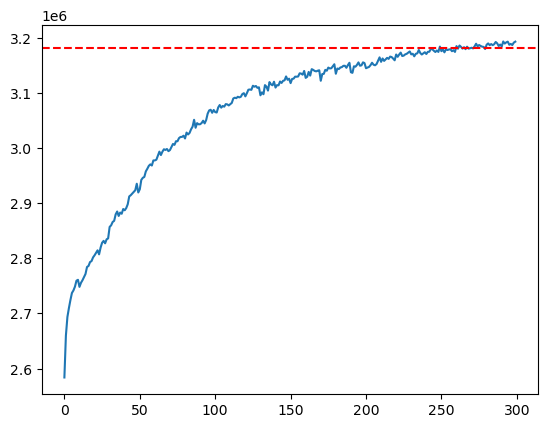

100%|██████████| 693758/693758 [01:38<00:00, 7030.10it/s]
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_26816\3985287644.py:67: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




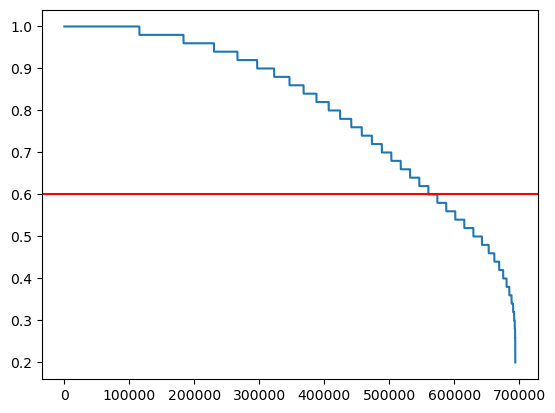

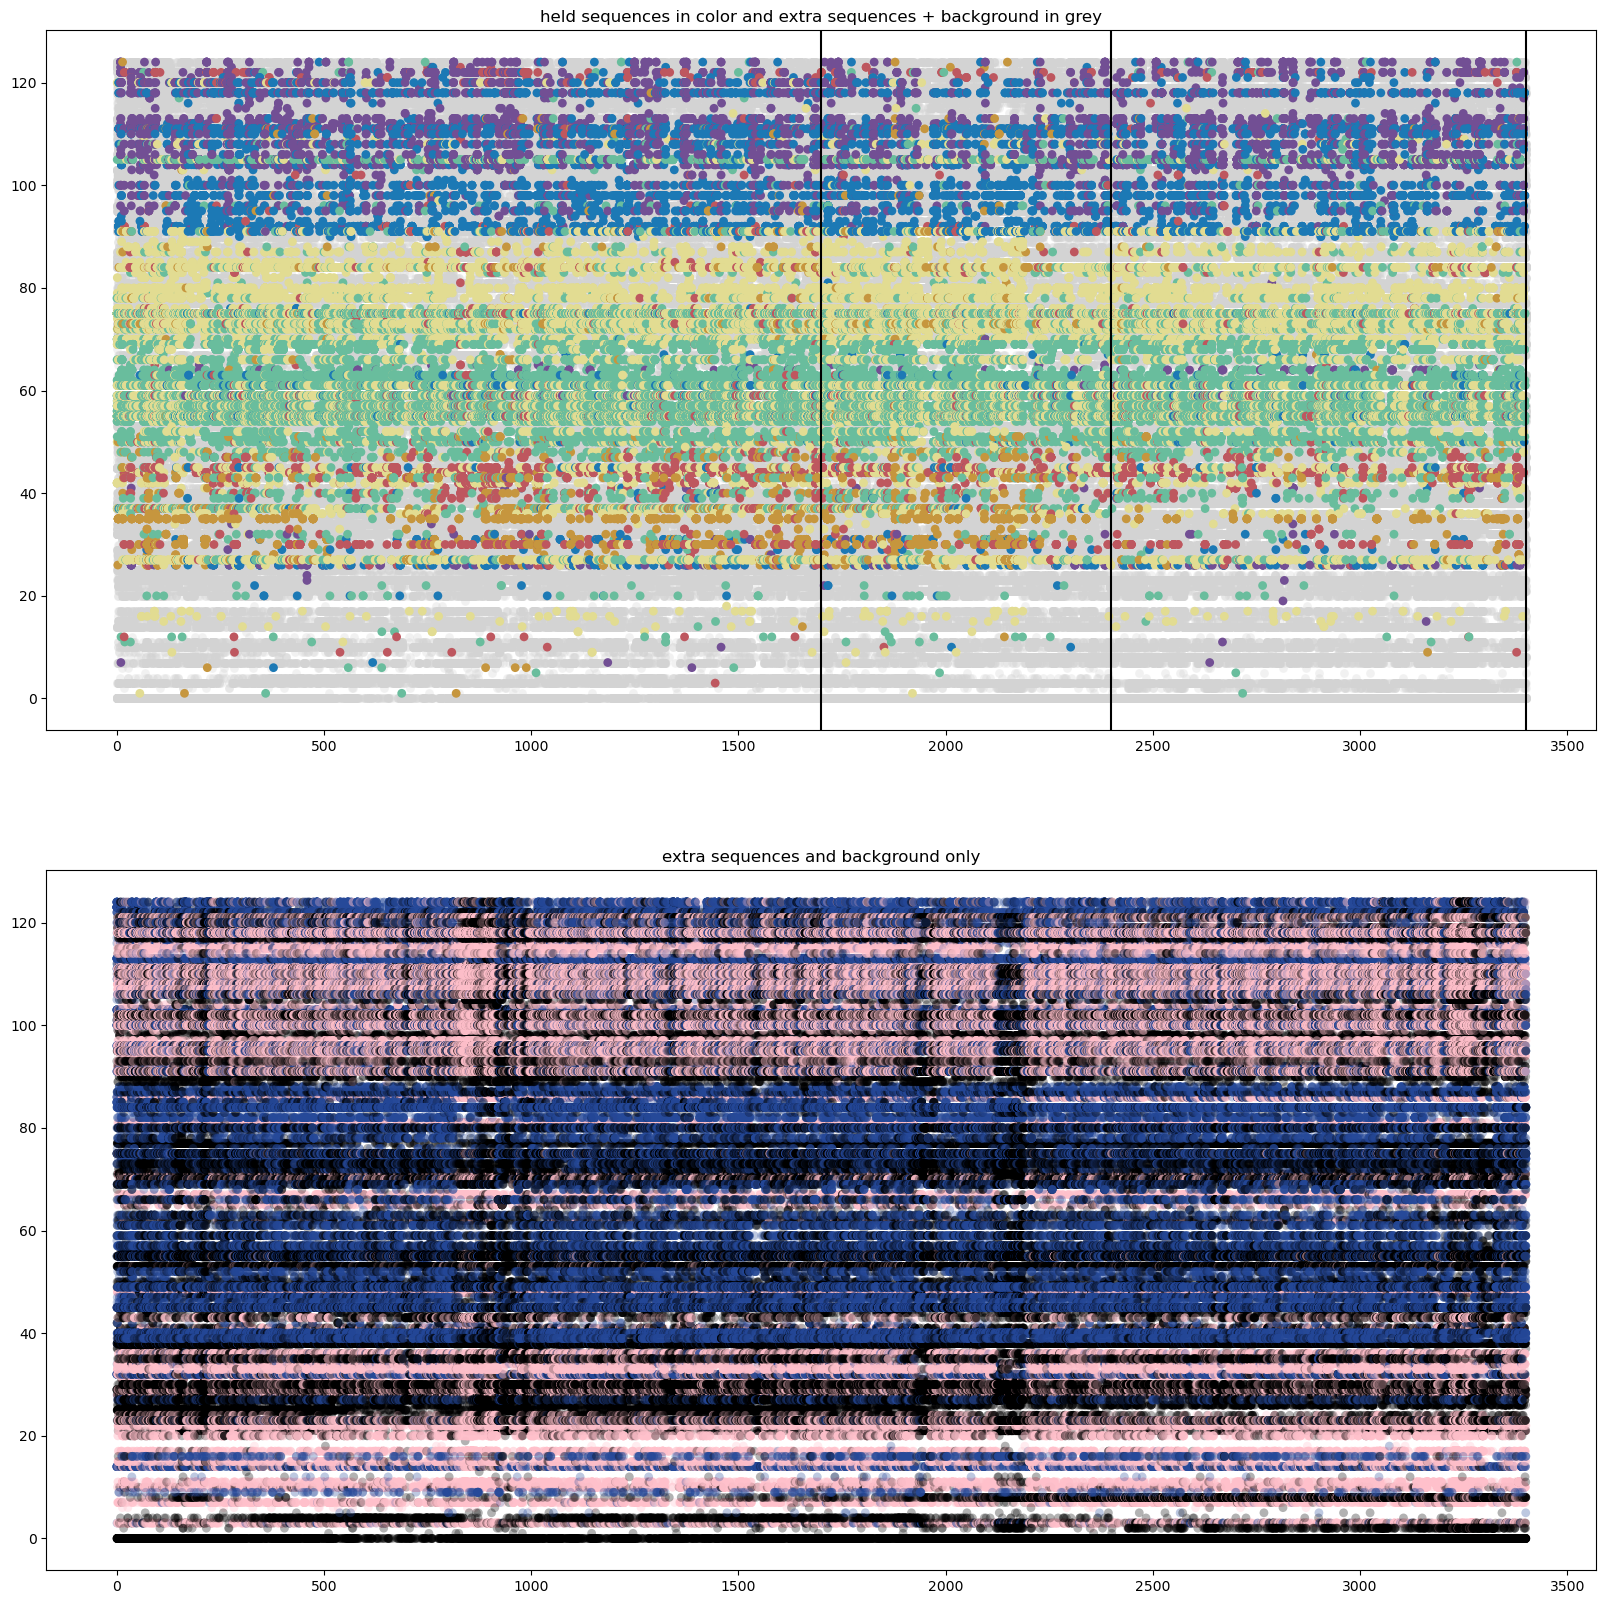

In [299]:
def find_corresponding(nums,df_dict):
    return [df_dict[num] for num in nums]

# load replays, mark rem and nrem times

PP_PATH = sleep_PPpath
mouse_session_recording =  mouse
             
DAT_PATH_2 = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
DAT_PATH_1 = r"Z:\projects\sequence_squad\organised_data\animals\\"

## set ppseq file
for file_ in os.listdir(PP_PATH):
    if mouse_session_recording in file_:
        pp_file = file_

#     pp_file= '262_1_4_run_2106023_2357'


# load in paths for that specific mouse and recording

try:
    mir,mouse_session_recording,save_path,tracking_path,dat_path = load_in_paths(pp_file, PP_PATH, DAT_PATH_1,0,[])
except:
    mir,mouse_session_recording,save_path,tracking_path,dat_path = load_in_paths(pp_file, PP_PATH, DAT_PATH_2,0,[])
    

## load in PPseq output data
assignment_history_df,latent_event_history_df,seq_type_log_proportions_df,neuron_response_df,log_p_hist_df,unmasked_spikes_df,bkgd_log_proportions_array,behav_sync,transitions,behav_time_interval_start = load_PPSEQ_data(PP_PATH,pp_file,dat_path,mir)
# plot out log l curve 
plot_save_log_l_curve(log_p_hist_df,save_path)

# ---filter_across_itterations---------------------------------------------------------------------------------------------------------------------------------------------------------------    
# Initialize an empty df to store the result
seq_types_df = pd.DataFrame()
# Iterate through the range
# for iteration_ in tqdm(range(400, 500)):
for iteration_ in tqdm(range(250, 300)):
    # Extract the relevant column from the assignment history dataframe
    assignment_history_df_split = assignment_history_df[str(list(assignment_history_df)[iteration_])]
    # Get the index of the -1 split markers in the latent event history dataframe
    end_markers = latent_event_history_df.loc[latent_event_history_df['seq_type'] == -1.0].index
    # Extract the relevant portion of the latent event history dataframe
    latent_event_history_df_split =  latent_event_history_df[end_markers[iteration_-1]:end_markers[iteration_]]
    # Create a dictionary from the dataframe for faster lookups
    df_dict = latent_event_history_df_split.set_index('assignment_id')['seq_type'].to_dict()
    # Match the sequence ID to the sequence type
    seq_type = find_corresponding(assignment_history_df_split,df_dict)
    # Append the result to the df
    seq_types_df[str(iteration_+1)] = seq_type
proportion = []
seq_type = []
for index in tqdm(range(len(seq_types_df))):
    row = seq_types_df.loc[index]
    seq_type += [statistics.mode(row)] 
    proportion += [np.count_nonzero(row == statistics.mode(row)) / len(row)]
# add seq type to dataframe
unmasked_spikes_df['sequence_type'] = seq_type
# add seq type to dataframe
unmasked_spikes_df['seq_confidence'] = proportion

# ## filter for background confidence :-------------------------------------------------------------------------------------------------------------------------------------------------------------------    
thresh = max(proportion) *.60 ### 
plt.plot(np.sort(proportion)[::-1])
plt.axhline(y = thresh, color = 'r', linestyle = '-')
unmasked_spikes_df['sequence_type_adjusted'] = seq_type
unmasked_spikes_df.sequence_type_adjusted[np.where(unmasked_spikes_df.seq_confidence < thresh)[0]] = -1
SaveFig('filtering_curve.png',save_path)

## load in colors and order from awake data -------------------------------------------------------------------------------------------------------------------------------------------------------------------    
found = False
# awake_PP_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\AP5_data\awake\\"
awake_PP_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\expert\awake\\"
for file_ in os.listdir(awake_PP_path):
    if mouse_session_recording in file_:
        awake_file = file_
        found = True
if not found:
    awake_PP_path = r"Z:\projects\sequence_squad\ppseq_finalised_publication_data\learning\awake\\"
    for file_ in os.listdir(awake_PP_path):
        if mouse_session_recording in file_:
            awake_file = file_
            found = True

ordered_preferred_type = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'ordered_preferred_type')
neuron_index = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')
# colors = pd.read_pickle(awake_PP_path + awake_file + r"\analysis_output\reordered_recolored\\" + 'colors')
spikes_df = unmasked_spikes_df
colors += ['pink','lightblue', 'k'] 

############### plot simple rasters ------------------------------
interval_end_points,neuron_order = plot_data_raster(behav_time_interval_start, spikes_df, neuron_index, colors, save_path + 'all_data_raster.png')


interactive - to find rem/nrem replay 

In [300]:
def load_in_sleep_state_scoring(mouse):
    # print('---------------------')
    # print('searching for sleep state scoring')
    # determine organised data paths for the current mouse
    if mouse.split('_')[0].isdigit():
        org_dat_path = r"Z:\projects\sequence_squad\organised_data\animals\\"
        old_data = True
    else:
        org_dat_path = r"Z:\projects\sequence_squad\revision_data\organised_data\animals\\"
        old_data = False
    org_mouse_file = None
    for file in os.listdir(org_dat_path):
        if mouse.split('_')[0] in file:
            # if the implant = implant
            if mouse.split('_')[1] == file.split('_')[-1][-1]:
                # print(f'1. mouse file found: \033[1m{file}\033[0m')
                org_mouse_file = os.path.join(org_dat_path,file)
    mouse_org_data_path = None
    for recording in os.listdir(org_mouse_file):
        if mouse.split('_')[-1] == recording.split('ing')[-1].split('_')[0]:
            # print(f'2. recording found: \033[1m{recording}\033[0m')
            mouse_org_data_path = os.path.join(org_mouse_file,recording) + r'\\'

    # load in sleep scoring data 

    sleep_state_score_path = mouse_org_data_path + r"\ephys\LFP\\"
    if not os.path.exists(sleep_state_score_path):
        sleep_state_score_path =  mouse_org_data_path + '/ephys/probeA/LFP/'

    if not os.path.exists(sleep_state_score_path):
        print(f"Sleep state score files not found for {mouse}.")
    else:
        nrem_start_ends = np.load(sleep_state_score_path + "presleep_nrem_start_ends.npy", allow_pickle=True)
        rem_start_ends = np.load(sleep_state_score_path + "presleep_rem_start_ends.npy", allow_pickle=True)
    #     print (f"\033[1mSuccess!\033[0m Loaded sleep state score files for mouse: {mouse}.")

    # print('----------------------')
        
    return nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data

def get_chunk_state_times(rem_start_ends, chunk_time):
    chunk_start, chunk_end = chunk_time
    chunk_length = chunk_end - chunk_start
    chunk_rem_times = []

    for start, end in rem_start_ends:
        # Check overlap instead of start-only
        if end >= chunk_start and start <= chunk_end:
            start_chunk_rebased = max(0, start - chunk_start)
            end_chunk_rebased = (end - chunk_start)

            # Clip to chunk boundaries
            start_chunk_rebased = max(0, start_chunk_rebased)
            end_chunk_rebased = min(chunk_length, end_chunk_rebased)

            chunk_rem_times.append([start_chunk_rebased, end_chunk_rebased])

    return chunk_rem_times

# load sync file
behav_sync_file = load_sync_file(dat_path,mouse)
sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]

# account for offset (to save space I trimmed the spindles down to just the sleep period)
ephys_times_offset = behav_time_interval_start - sleep_period_ephys_start_time


# only rem/nrem events... 
## REM / NREM times only
# load in sleep state scoring
nrem_start_ends,rem_start_ends,mouse_org_data_path,old_data = load_in_sleep_state_scoring(mouse)

    
chunk_nrem_times = []
chunk_rem_times = []
cum_period_time = 0

for chunk_time in ephys_times_offset:
    # get relevant rem/nrem times for chunk
    chunk_nrem = get_chunk_state_times(nrem_start_ends, chunk_time)
    chunk_rem = get_chunk_state_times(rem_start_ends, chunk_time)

    if len(chunk_nrem) > 0:
        chunk_nrem_times += (np.array(chunk_nrem) + cum_period_time).tolist()
    if len(chunk_rem) > 0:
        chunk_rem_times += (np.array(chunk_rem) + cum_period_time).tolist()

    cum_period_time += (chunk_time[1] - chunk_time[0])



In [301]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "browser"

timeframe = [0, 2000]

# Compute interval lengths and endpoints
interval_lengths = np.diff(behav_time_interval_start, axis=1).ravel()
total_time = interval_lengths.sum()
interval_end_points = np.cumsum(interval_lengths)

# Mask spikes in timeframe
mask = spikes_df.timestamp.between(timeframe[0], timeframe[1])

# Define neuron order directly
neuron_order = np.argsort(neuron_index)[(spikes_df.neuron - 1).astype(int)]

# Background mask
background_keep_mask = spikes_df.sequence_type_adjusted.lt(0) | spikes_df.sequence_type_adjusted.ge(7)

# Foreground mask
foreground_mask = spikes_df.sequence_type_adjusted.isin([0, 1, 2, 3, 4, 5, 6])

# Build figure
fig = go.Figure()

# Background spikes
fig.add_trace(go.Scattergl(
    x=spikes_df.loc[mask & background_keep_mask, "timestamp"],
    y=neuron_order[mask & background_keep_mask],
    mode="markers",
    marker=dict(size=4, color="lightgrey", opacity=0.3),
    name="background"
))

# Foreground spikes
c_ = np.array(colors)[spikes_df.loc[mask & foreground_mask, "sequence_type_adjusted"].astype(int)]
fig.add_trace(go.Scattergl(
    x=spikes_df.loc[mask & foreground_mask, "timestamp"],
    y=neuron_order[mask & foreground_mask],
    mode="markers",
    marker=dict(size=4, color=c_, opacity=1),
    name="foreground"
))

# Layout
fig.update_layout(
    width=1200,
    height=600,
    xaxis=dict(title="Timestamp", rangeslider=dict(visible=True)),
    yaxis=dict(title="Neuron Order"),
    title="Interactive Spike Raster"
)


# Add NREM shaded regions
for start_end in chunk_nrem_times:
    start = start_end[0]
    end = start_end[-1]
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="lightblue", opacity=0.6,
        layer="below", line_width=0,
        annotation_text="NREM", annotation_position="top left",
        annotation=dict(font_size=10, font_color="blue")
    )

# Add REM shaded regions
for start_end in chunk_rem_times:
    start = start_end[0]
    end = start_end[-1]
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="pink", opacity=0.6,
        layer="below", line_width=0,
        annotation_text="REM", annotation_position="top left",
        annotation=dict(font_size=10, font_color="darkred")
    )


fig.show()


interactive tp find spindle replay 

In [302]:
spindle_bandpassed = np.load(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\" + mouse + r"\processed_data\zscored_spindle_bandpassed.npy")
LFP_raw = np.load(r"Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\" + mouse + r"\processed_data\average_lfp.npy")

spindle_events = np.load(r'Z:\projects\sequence_squad\revision_data\emmett_revisions\oscillations\striatum_lfp\expert\\' + mouse + r"\analysis\spindle_events.npy", allow_pickle=True)


# load sync file
behav_sync_file = load_sync_file(dat_path,mouse)
sleep_period_ephys_start_time = behav_sync_file.Camera_time_Ephys_Aligned[0]

# account for offset (to save space I trimmed the spindles down to just the sleep period)
ephys_times_offset = behav_time_interval_start - sleep_period_ephys_start_time



relevant_spind_bp = []
relevant_LFP = []
spindle_event_times =[]
cum_period_time = 0
for period in ephys_times_offset:
    relevant_spind_bp += list(spindle_bandpassed[int(period[0] * 2500): int(period[-1] * 2500)])
    relevant_LFP += list(LFP_raw[int(period[0] * 2500): int(period[-1] * 2500)])
    
    for event in spindle_events:
        if event['start_time'] - sleep_period_ephys_start_time  > period[0]:
            if event['end_time']  - sleep_period_ephys_start_time < period[-1]:
                start = cum_period_time + ((event['start_time'] - sleep_period_ephys_start_time) - period[0])
                end = cum_period_time + ((event['end_time'] - sleep_period_ephys_start_time) - period[0])
                spindle_event_times += [[start,end]]
                
    cum_period_time += np.diff(period)
                

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import plotly.io as pio
pio.renderers.default = "browser"

timeframe = [0, 4000]

# Compute interval lengths and endpoints
interval_lengths = np.diff(behav_time_interval_start, axis=1).ravel()
total_time = interval_lengths.sum()
interval_end_points = np.cumsum(interval_lengths)

# Mask spikes in timeframe
mask = spikes_df.timestamp.between(timeframe[0], timeframe[1])

# Define neuron order directly
neuron_order = np.argsort(neuron_index)[(spikes_df.neuron - 1).astype(int)]

# Background mask
background_keep_mask = spikes_df.sequence_type_adjusted.lt(0) | spikes_df.sequence_type_adjusted.ge(7)

# Foreground mask
foreground_mask = spikes_df.sequence_type_adjusted.isin([0, 1, 2, 3, 4, 5, 6])

# -----------------------------
# Build subplots: 2 rows, shared x-axis
# -----------------------------
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.05,
    subplot_titles=("Interactive Spike Raster", "Spindle Bandpassed Signal")
)

# -----------------------------
# Row 1: Spike raster
# -----------------------------
fig.add_trace(go.Scattergl(
    x=spikes_df.loc[mask & background_keep_mask, "timestamp"],
    y=neuron_order[mask & background_keep_mask],
    mode="markers",
    marker=dict(size=4, color="lightgrey", opacity=0.3),
    name="background"
), row=1, col=1)

c_ = np.array(colors)[spikes_df.loc[mask & foreground_mask, "sequence_type_adjusted"].astype(int)]
fig.add_trace(go.Scattergl(
    x=spikes_df.loc[mask & foreground_mask, "timestamp"],
    y=neuron_order[mask & foreground_mask],
    mode="markers",
    marker=dict(size=4, color=c_, opacity=1),
    name="foreground"
), row=1, col=1)

# -----------------------------
# Row 2: Spindle bandpassed signal
# -----------------------------
# Time axis for continuous signal
spindle_time = np.arange(len(relevant_spind_bp)) / 2500.0  # seconds

fig.add_trace(go.Scatter(
    x=spindle_time,
    y=relevant_spind_bp,
    mode="lines",
    line=dict(color="blue", width=1),
    name="Spindle Bandpassed"
), row=2, col=1)

# Highlight spindle events
for start, end in spindle_event_times:
    fig.add_vrect(
        x0=start, x1=end,
        fillcolor="red", opacity=0.2, line_width=0,
        row=2, col=1
    )

# -----------------------------
# Layout
# -----------------------------
fig.update_layout(
    width=1200,
    height=800,
    xaxis=dict(title="Timestamp"),
    yaxis=dict(title="Neuron Order"),
    xaxis2=dict(title="Time (s)"),
    yaxis2=dict(title="Amplitude"),
    title="Interactive Spike Raster + Spindle Signal",
    showlegend=False
)

fig.show()


In [ ]:
### add spindles underneath
## add rem/nrem shading 

# make plot for figure

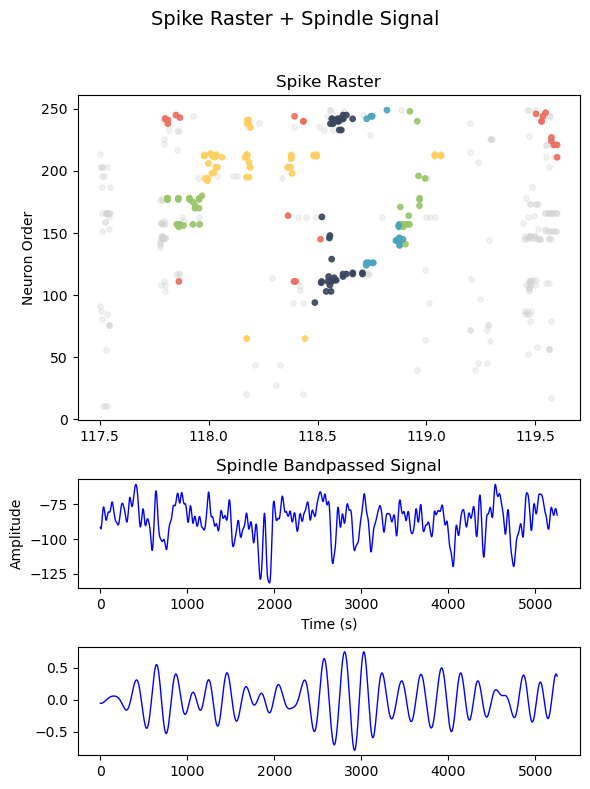

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

# --- Inputs ---
# assuming you already have:
# spikes_df, neuron_index, colors, spindle_bandpassed, spindle_event_times, relevant_spind_bp, etc.

timeframe = [117.5, 119.6]

# Compute interval lengths and endpoints
interval_lengths = np.diff(behav_time_interval_start, axis=1).ravel()
total_time = interval_lengths.sum()
interval_end_points = np.cumsum(interval_lengths)

# Mask spikes in timeframe
mask = spikes_df.timestamp.between(timeframe[0], timeframe[1])

# Define neuron order directly
neuron_order = np.argsort(neuron_index)[(spikes_df.neuron - 1).astype(int)]

# Masks for plotting
background_keep_mask = spikes_df.sequence_type_adjusted.lt(0) | spikes_df.sequence_type_adjusted.ge(7)
foreground_mask = spikes_df.sequence_type_adjusted.isin([0, 1, 2, 3, 4, 5, 6])

# Time axis for continuous signal
spindle_time = np.arange(len(relevant_spind_bp)) / 2500.0  # seconds

# --- Figure layout ---
fig,[ax1,ax2,ax3] = plt.subplots(3,1,figsize=(6, 8),gridspec_kw={'height_ratios': [3, 1, 1]})


# -----------------------------
# Row 1: Spike raster
# -----------------------------

ax1.scatter(
    spikes_df.loc[mask & background_keep_mask, "timestamp"],
    neuron_order[mask & background_keep_mask],
    s=15, c="lightgrey", alpha=0.3, label="background"
)

foreground_colors = np.array(colors)[spikes_df.loc[mask & foreground_mask, "sequence_type_adjusted"].astype(int)]
ax1.scatter(
    spikes_df.loc[mask & foreground_mask, "timestamp"],
    neuron_order[mask & foreground_mask],
    s=15, c=foreground_colors, alpha=0.9, label="foreground"
)

ax1.set_ylabel("Neuron Order")
ax1.set_title("Spike Raster")

# -----------------------------
# Row 2: Spindle bandpassed signal
# -----------------------------


ax3.plot(relevant_spind_bp[int(timeframe[0]*2500):int(timeframe[-1]*2500)], color="blue", linewidth=1)

ax2.plot(relevant_LFP[int(timeframe[0]*2500):int(timeframe[-1]*2500)], color="blue", linewidth=1)


# for start, end in spindle_event_times:
#     ax2.axvspan(start, end, color="red", alpha=0.2)

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude")
ax2.set_title("Spindle Bandpassed Signal")

# --- Formatting ---
plt.suptitle("Spike Raster + Spindle Signal", fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])

SaveFig('spindle_replay_example.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')


save this stuff out 

In [ ]:
# out_path = r"C:\Users\Emmett Thompson\Documents\plots\\"

# ### make save out data 
# spikes_segment_df = spikes_df[mask][spikes_df[mask].sequence_type_adjusted.isin([0, 1, 2, 3, 4, 5, 6,-1])].reset_index()
# spikes_segment_df['background'] = list(spikes_segment_df.sequence_type_adjusted.lt(0).values)
# spindle_segment = relevant_spind_bp[int(timeframe[0]*2500):int(timeframe[-1]*2500)]
# LFP_segment = relevant_LFP[int(timeframe[0]*2500):int(timeframe[-1]*2500)]

# # save out df
# spikes_segment_df = spikes_segment_df.sort_values(by="timestamp")
# spikes_segment_df.to_csv(out_path + 'segment_spikes_df.csv')
# #save out lfp and spindle segments
# np.save(out_path + 'spindle_segment.npy',spindle_segment)
# np.save(out_path + 'LFP_segment.npy',LFP_segment)
# np.save(out_path + 'sequence_neuron_index.npy',neuron_index)
# np.save(out_path + 'sequence_colors.npy',colors)
# ## save out 


make a plot from saved data 

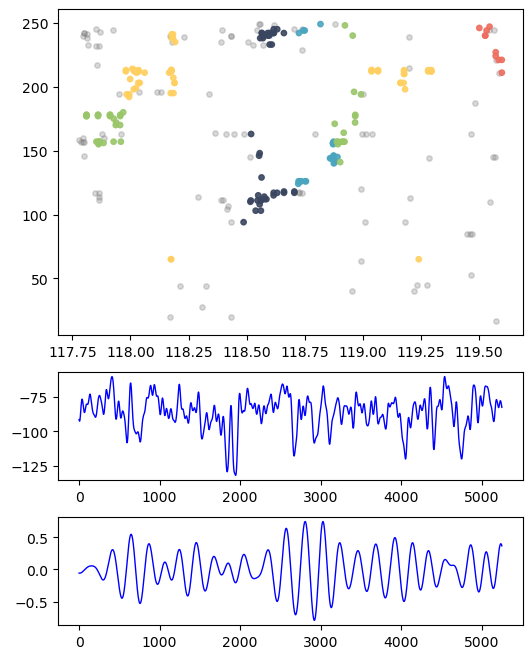

In [282]:
segment_spikes_df = pd.read_csv(out_path + 'segment_spikes_df.csv')
spindle_segment= np.load(out_path + 'spindle_segment.npy')
LFP_segment= np.load(out_path + 'LFP_segment.npy')
sequence_neuron_index = np.load(out_path + 'sequence_neuron_index.npy')
sequence_colors = np.load(out_path + 'sequence_colors.npy')

neuron_order = np.argsort(neuron_index)[(segment_spikes_df.neuron - 1).astype(int)]

# --- Figure layout ---
fig,[ax1,ax2,ax3] = plt.subplots(3,1,figsize=(6, 8),gridspec_kw={'height_ratios': [3, 1, 1]})

ax1.scatter(
    segment_spikes_df[segment_spikes_df.background].timestamp,
    neuron_order[segment_spikes_df.background],
    s=15, c='grey', alpha=0.3, label="background"
)


sequence_spikes_colours = np.array(sequence_colors)[segment_spikes_df[segment_spikes_df.background == False].sequence_type_adjusted.values.astype(int)]

ax1.scatter(
    segment_spikes_df[segment_spikes_df.background == False].timestamp,
    neuron_order[segment_spikes_df.background == False],
    s=15, c=sequence_spikes_colours, alpha=0.9, label="forground"
)

ax3.plot(spindle_segment, color="blue", linewidth=1)

ax2.plot(LFP_segment, color="blue", linewidth=1)

SaveFig('spindle_replay_example.pdf',r'C:\Users\Emmett Thompson\Documents\plots\\')

In [124]:
# less than zero 
colors = ['---',
'#4ba5bf',
'#ffd061',
'#ed6e5f',
'#C6963E',
'#9ac66a',
'#3a465f',
'#264999']



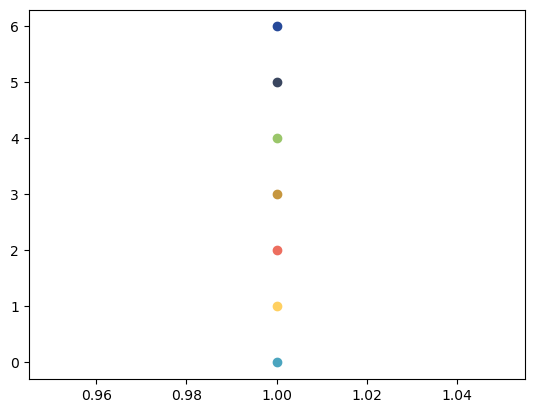

In [269]:
for i,index in enumerate(colors[1::]):
    plt.plot(1,i,'o',c = index)

In [89]:
spikes_segment_df

index  neuron  timestamp  sequence_type  seq_confidence  \
0      1600     4.0   117.0030            7.0            0.86   
1      1601     4.0   117.1221            7.0            0.94   
2      1602     4.0   117.1322            7.0            0.96   
3      1603     4.0   117.4824            7.0            0.72   
4      2518     5.0   117.1149            7.0            0.82   
..      ...     ...        ...            ...             ...   
930  725633   252.0   117.5099            7.0            0.94   
931  725634   252.0   117.5456            7.0            0.90   
932  725635   252.0   119.4848            8.0            0.54   
933  725636   252.0   119.6985           -1.0            0.76   
934  725637   252.0   120.5100           -1.0            1.00   

     sequence_type_adjusted  background  
0                       7.0       False  
1                       7.0       False  
2                       7.0       False  
3                       7.0       False  
4                       7.0       False  
..                      ...         ...  
930                     7.0       False  
931                     7.0       False  
932                    -1.0        True  
933                    -1.0        True  
934                    -1.0        True  

[935 rows x 7 columns]

In [75]:
spikes_segment_df

index  neuron  timestamp  sequence_type  seq_confidence  \
0      1600     4.0   117.0030            7.0            0.86   
1      1601     4.0   117.1221            7.0            0.94   
2      1602     4.0   117.1322            7.0            0.96   
3      1603     4.0   117.4824            7.0            0.72   
4      2518     5.0   117.1149            7.0            0.82   
..      ...     ...        ...            ...             ...   
930  725633   252.0   117.5099            7.0            0.94   
931  725634   252.0   117.5456            7.0            0.90   
932  725635   252.0   119.4848            8.0            0.54   
933  725636   252.0   119.6985           -1.0            0.76   
934  725637   252.0   120.5100           -1.0            1.00   

     sequence_type_adjusted  
0                       7.0  
1                       7.0  
2                       7.0  
3                       7.0  
4                       7.0  
..                      ...  
930                     7.0  
931                     7.0  
932                    -1.0  
933                    -1.0  
934                    -1.0  

[935 rows x 6 columns]

In [52]:
2500*np.diff(timeframe)

array([50000])

In [51]:
np.linspace(0,10,20)

array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ])

[np.float64(-0.12958519270376795),
 np.float64(-0.13662814560506964),
 np.float64(-0.14357279331872516),
 np.float64(-0.15041231994636153),
 np.float64(-0.15713997697055915),
 np.float64(-0.16374909084835304),
 np.float64(-0.17023307056855333),
 np.float64(-0.1765854151632047),
 np.float64(-0.18279972116350993),
 np.float64(-0.1888696899905619),
 np.float64(-0.19478913527126152),
 np.float64(-0.20055199006984745),
 np.float64(-0.2061523140255253),
 np.float64(-0.2115843003867595),
 np.float64(-0.216842282932878),
 np.float64(-0.22192074277374413),
 np.float64(-0.2268143150183636),
 np.float64(-0.23151779530342254),
 np.float64(-0.23602614617289575),
 np.float64(-0.24033450330002024),
 np.float64(-0.24443818154309654),
 np.float64(-0.2483326808267632),
 np.float64(-0.2520136918405844),
 np.float64(-0.25547710154699765),
 np.float64(-0.25871899849088814),
 np.float64(-0.2617356779032873),
 np.float64(-0.26452364659193667),
 np.float64(-0.2670796276117121),
 np.float64(-0.2694005647081648

In [36]:
spindle_event_times

[[np.float64(15.2692997157028), np.float64(15.570499715700862)],
 [np.float64(24.895699715701994), np.float64(25.22649971570172)],
 [np.float64(32.412099715702425), np.float64(32.72569971570192)],
 [np.float64(104.47729971570152), np.float64(104.79769971570204)],
 [np.float64(143.53969971570223), np.float64(143.94889971570228)],
 [np.float64(150.0200997157026), np.float64(150.43889971570206)],
 [np.float64(186.86769971570175), np.float64(187.24289971570215)],
 [np.float64(190.25929971570258), np.float64(190.56089971570145)],
 [np.float64(199.56769971570247), np.float64(200.00529971570177)],
 [np.float64(240.17009971570224), np.float64(240.55569971570185)],
 [np.float64(249.0304997157018), np.float64(249.35849971570133)],
 [np.float64(253.50329971570136), np.float64(253.97929971570193)],
 [np.float64(268.8392997157025), np.float64(269.29649971570143)],
 [np.float64(269.60529971570213), np.float64(269.9792997157019)],
 [np.float64(270.4724997157027), np.float64(270.81129971570226)],
 [np

In [ ]:
# plot out the replay spikes and with rem and nrem periods defined. 

In [ ]:
# work out some kind of interacitve searcher? 

In [ ]:


#rem/nrem + spindles 

# plot nice example awake replays 

# search for good replay 


# save this data out

# load it and make figure plot

In [ ]:
# load in, align and plot spindles. (then save this segmetn out as well )